In [1]:
import warnings
import math
import numpy as np # to use numpy arrays instead of lists
import pandas as pd # DataFrame (table)
import matplotlib.pyplot as plt # to plot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.decomposition as sk # to compute PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import Callback
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [7]:
def main():
    warnings.filterwarnings("ignore")

    datos = leeDatos()
    #print(datos)

    #estados = [col[:] for col in datos.columns[:4]]
    estados = datos.columns[:4]
    #print(datos[estados])

    estados = ['Nacional', 'MEXICO', 'DISTRITO FEDERAL', 'GUANAJUATO', 'JALISCO', 'MORELOS','PUEBLA','QUERETARO']
    misDatos = datos[estados]
    print(datos[estados])

    graficaDatos(misDatos.iloc[0:290,:])#0:305])

    datosLin = linealizar(misDatos.iloc[0:290,:])#0:4])

    graficaDatos(datosLin)

    computeCorr(datosLin)

    num_comp = 3
    preprocessData = computePCA(datosLin, num_comp=num_comp)  #normSet

    graficaDatos(preprocessData)
    print("\n")

    ts_size = .25
    [trainSet, testSet] = splitDataSet(preprocessData, test_size=ts_size, randSplit=False)

    #graficaDatos(trainSet)
    #graficaDatos(testSet)

    [trainModel, testModel] = metodosML(trainSet, testSet)

    graficaDatos(trainModel)
    graficaDatos(testModel)

    #hyper(trainSet, testSet)



def leeDatos():

    dataSet = pd.read_csv("gdrive/MyDrive/Colab Notebooks/covid.csv", header=0, index_col=0)
    dataSet.index = pd.to_datetime(dataSet.index,format='%d/%m/%y',errors='ignore')

    return dataSet

def graficaDatos(dataSet=0):

    plt.figure()
    for i in range(len(dataSet.columns)):
        plt.plot(dataSet.iloc[:,i],label=dataSet.columns[i],marker=i+2,markevery=150)
    plt.grid(color='b',linestyle='dashed')
    plt.gcf().autofmt_xdate()
    plt.title('COVID-19', fontweight='bold')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.legend(loc='upper left')
    plt.show()

def linealizar(dataSet=0):
    """
    Normalize and smooth data
    """
    dataSet = dataSet.fillna(method='ffill')
    #dataSet = dataSet.dropna()

    # computing range of data for the regressions
    size = len(dataSet)
    x = range(size)
    numFeatures = len(dataSet.columns)

    for i in range(numFeatures):
        dataSet.iloc[:,i] = dataSet.iloc[:,i]  / dataSet.iloc[:,i].abs().max()
        polyCoef = np.polyfit(x, dataSet.iloc[:,i], 3)   # coefficients 10
        regModel = np.poly1d(polyCoef)              # equation
        regSpace = np.linspace(1, size, size)          # generate n numbers between a range
        dataSet.iloc[:,i] = regModel(regSpace)

    return dataSet

# compute PCA
def computeCorr(dataSet):
    """
    Compute CORRELATION
    """

    # correlation analysis
    correlation=dataSet.corr(method = 'pearson')
    print("==========================================================")
    print("                 CORRELATION ANALYSIS")
    print("----------------------------------------------------------")
    print(correlation)
    print("\n")


# compute PCA
def computePCA(dataSet, num_comp=3):
    """
    Compute PCA
    """
    features = dataSet
    features = features.drop([dataSet.columns[0]], axis=1)

    pca = sk.PCA(n_components=num_comp)
    principalComponents = pca.fit_transform(features)
    comp_names = ['P. Comp. {}'.format(i+1) for i in range(num_comp)]
    principalComp = pd.DataFrame(data = principalComponents.tolist(),
                                 columns = comp_names)
    principalComp.set_index(dataSet.index,inplace = True, drop=True)
    principalComp[dataSet.columns[0]] = dataSet[dataSet.columns[0]]
    cols = [dataSet.columns[0]] + sorted(comp_names)
    principalComp = principalComp[cols]
    print("==========================================================")
    print("                 PCA ANALYSIS")
    print("----------------------------------------------------------")
    print(principalComp)
    print("\n")

    # explained variance ratio
    varRatio = (pca.explained_variance_ratio_)*100
    dic = {'P. Comp. {}'.format(i+1): varRatio[i] for i in range(num_comp)}
    expVar = pd.DataFrame(dic, index=['Exp Var Ratio %'])

    # Principal axes in feature space, representing the directions of maximum variance
    # get the index of the most important feature on EACH component
    # LIST COMPREHENSION HERE
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(num_comp)]
    # get the names
    initial_feature_names = features.columns
    most_important_names = [initial_feature_names[most_important[i]] for i in range(num_comp)]
    # complete the dataframe
    # LIST COMPREHENSION HERE AGAIN
    dic = {'P. Comp. {}'.format(i+1): most_important_names[i] for i in range(num_comp)}
    #df = pd.DataFrame(dic.items()).T
    expVar = pd.concat([expVar, pd.DataFrame(dic, index =['Most Imp. F.'])])
    print(expVar)
    print("\n")

    return principalComp

# --------------------
# split data
def splitDataSet(dataSet=0, test_size=.2, randSplit=True):
    """
    Split data in train and test sets
    """

    train, test = train_test_split(dataSet, test_size=test_size, shuffle=randSplit)

    return [train, test]

# ML methods

In [8]:
def metodosML(dataSet=0, dataSet2=0):

    methodsUsed=['DT', 'RF', 'SVM', 'NN MLP']
    performanceHeaders=['RSS','SSR','TSS','R-Square','Adj. R-Square', 'AIC', 'APC', 'BIC']
    comperrHeaders=['MSE','RMSE', 'MAPE']
    errorHeaders=['Mean','Median', 'SD','25%','50%','75%','Min','Max','Range']
    modPerformance = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
    modPerformance.index.name = "Model Performance"
    comperr = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
    comperr.index.name = "Error Metrics"
    regError = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
    regError.index.name = "Relative Error"
    modPerformance3 = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
    modPerformance3.index.name = "Model Performance"
    comperr3 = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
    comperr3.index.name = "Error Metrics"
    regError3 = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
    regError3.index.name = "Relative Error"

    trainModel = pd.DataFrame()
    testModel = pd.DataFrame()
    yModel = pd.DataFrame()
    yModel3 = pd.DataFrame()
    trainModel['Raw Data'] = dataSet.iloc[:,0]
    testModel['Raw Data'] = dataSet2.iloc[:,0]
    sizeData=len(dataSet.columns)-1

    regr = DecisionTreeRegressor(max_depth=4)
    regr.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    # train data
    trainModel['Fitted DT'] = regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
    yModel['Fitted DT'] = trainModel['Fitted DT']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'DT', dataSet, 0, regError, comperr, modPerformance, 0)
    # test data
    testModel['Fitted DT'] = regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
    yModel3['Fitted DT'] = testModel['Fitted DT']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'DT', dataSet2, 0, regError3, comperr3, modPerformance3, 0)

    # Random Forest
    regr = RandomForestRegressor(n_estimators=4)
    regr.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    # train data
    trainModel['Fitted RT'] = regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
    yModel['Fitted RT'] = trainModel['Fitted RT']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'RT', dataSet, 0, regError, comperr, modPerformance, 1)
    # test data
    testModel['Fitted RT'] = regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
    yModel3['Fitted RT'] = testModel['Fitted RT']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'RT', dataSet2, 0, regError3, comperr3, modPerformance3, 1)
    print("aqui")
    print("Estimated Parameters:")
    print(f"Number of trees (n_estimators): {regr.n_estimators}")
    print(f"Max depth of trees (max_depth): {regr.max_depth}")

    # SVM regression
    regr = svm.SVR(kernel="poly", degree=4, coef0=1)
    regr.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    # train data
    trainModel['Fitted SVM'] = regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
    yModel['Fitted SVM'] = trainModel['Fitted SVM']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'SVM', dataSet, 0, regError, comperr, modPerformance, 2)
    # test data
    testModel['Fitted SVM'] = regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
    yModel3['Fitted SVM'] = testModel['Fitted SVM']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'SVM', dataSet2, 0, regError3, comperr3, modPerformance3, 2)


    # NN MLP regression
    # Neural Networks TF
    input_shape=dataSet.iloc[:,1].to_numpy().reshape(len(dataSet),1)[0].shape
    dropout_rate = 0.25
    model = Sequential([
                        Flatten(input_shape=(input_shape)),
                        Dense(32, activation='relu'),#128
                        Dropout(dropout_rate),
                        Dense(16, activation='relu'),#128
                        Dropout(dropout_rate),
                        #BatchNormalization(),
                        #Dense(4, activation='relu'),#64
                        #Dropout(dropout_rate),
                        Dense(1)
                        ])

    opt = tf.keras.optimizers.SGD()
    loss_fun = 'mean_squared_error'
    acc = tf.keras.metrics.MeanAbsoluteError()

    model.compile(
        optimizer=opt,
        loss=loss_fun,
        metrics=[acc]
        )

    print(model.summary())
    print("\n")

    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(mode='min', monitor='mean_absolute_error', patience=2)
    callbacks = [learning_rate_reduction]
    history = model.fit(dataSet.iloc[:,1].to_numpy().reshape(len(dataSet),1),
                        dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1),
                        validation_split=0.15, epochs=20, batch_size=25, callbacks=callbacks)

    fig = plt.figure()
    fig.add_subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Loss vs Epochs")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    fig.add_subplot(122)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title("Mean Absolute Error vs Epochs")
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    print(model.evaluate(dataSet.iloc[:,1].to_numpy().reshape(len(dataSet),1), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1), verbose=2))
    print("\n")

    #### predict train data ######
    trainModel['Fitted NN'] = model.predict(dataSet.iloc[:,1].to_numpy().reshape(len(dataSet),1))
    yModel['Fitted NN'] = trainModel['Fitted NN']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'NN', dataSet, 0, regError, comperr, modPerformance, 3)

    # test data
    testModel['Fitted NN'] = model.predict(dataSet2.iloc[:,1].to_numpy().reshape(len(dataSet2),1))
    yModel3['Fitted NN'] = testModel['Fitted NN']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'NN', dataSet2, 0, regError3, comperr3, modPerformance3, 3)


    print("=======================================================================")
    print("                      MODEL PERFORMANCE COMPARISON")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(modPerformance.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print("-----------------------------------------------------------------------")
    print(modPerformance3.T)
    print("=======================================================================")
    print("                      ERROR METRICS")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(comperr.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print(comperr3.T)
    print("=======================================================================")
    print("                      MAPE (RELATIVE ERROR) COMPARISON")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(regError.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print("-----------------------------------------------------------------------")
    print(regError3.T)
    print("\n")


    plt.figure()
    plt.plot(yModel3['Fitted DT'], yModel3['Residuals DT'],'o', color='g',label='Residuals')
    plt.grid(color='b',linestyle='dashed')
    plt.axhline(y=0, color='red')
    plt.title("DT Model Residuals", fontweight='bold')
    plt.xlabel('Predictor')
    plt.ylabel('Residuals')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure()
    plt.plot(yModel3['Rel Error_DT'], color='orange',label='Relative Error', linestyle='--')
    plt.grid(color='b',linestyle='dashed')
    plt.gcf().autofmt_xdate()
    #plt.margins(x=-.4, y=-0.15)
    plt.title('MAPE DT', fontweight='bold')
    plt.xlabel('Value')
    plt.ylabel('Date (t)')
    plt.legend(loc='upper right')
    plt.show()


    return [trainModel, testModel]

# --------------------
# create performance tables
def compareMethod(yModel, method, dataSet, y, regError, comperr, modPerformance, i):
    name_fit = 'Fitted ' + method
    name_res = 'Residuals ' + method
    name_err = 'Rel Error_' + method

    size = len(yModel)

    # compute residuals and relative error
    yModel[name_res] = dataSet.iloc[:,y] - yModel[name_fit]
    yModel[name_err] = (1-(yModel[name_fit]/dataSet.iloc[:,y])).abs()
    regError.iloc[i,0] = yModel[name_err].mean(axis=0)
    regError.iloc[i,1] = yModel[name_err].median(axis=0)
    regError.iloc[i,2] = yModel[name_err].std(axis=0)
    regError.iloc[i,3] = yModel[name_err].quantile(q=.25)
    regError.iloc[i,4] = yModel[name_err].quantile(q=.5)
    regError.iloc[i,5] = yModel[name_err].quantile(q=.75)
    regError.iloc[i,6] = yModel[name_err].min()
    regError.iloc[i,7] = yModel[name_err].max()
    regError.iloc[i,8] = regError.iloc[i,7] - regError.iloc[i,6]

    # Models Performance
    modPerformance.iloc[i,0] = (yModel[name_res]**2).sum()
    modPerformance.iloc[i,1] = ((yModel[name_fit]-dataSet.iloc[:,y].mean(axis=0))**2).sum()
    modPerformance.iloc[i,2] = modPerformance.iloc[i,0]+modPerformance.iloc[i,1]
    modPerformance.iloc[i,3] = 1-modPerformance.iloc[i,0]/modPerformance.iloc[i,2]
    modPerformance.iloc[i,4] = 1-(1-modPerformance.iloc[i,3])*((size-1)/(size-4-1))
    modPerformance.iloc[i,5] = 4*math.log(size)+size*math.log(modPerformance.iloc[i,0]/size)
    modPerformance.iloc[i,6] = 4*2/size+math.log(modPerformance.iloc[i,0])
    modPerformance.iloc[i,7] = 4*2+size*math.log(modPerformance.iloc[i,0]/size)

    # error metrics
    comperr.iloc[i,0] = modPerformance.iloc[i,0]/size
    comperr.iloc[i,1] = comperr.iloc[i,0]**(1/2)
    comperr.iloc[i,2] = regError.iloc[i,0]

    return (yModel, regError, comperr, modPerformance)

# ML2

In [4]:
def metodosML2(dataSet=0, dataSet2=0):

    methodsUsed=['DT', 'RF', 'SVM', 'NN MLP']
    performanceHeaders=['RSS','SSR','TSS','R-Square','Adj. R-Square', 'AIC', 'APC', 'BIC']
    comperrHeaders=['MSE','RMSE', 'MAPE']
    errorHeaders=['Mean','Median', 'SD','25%','50%','75%','Min','Max','Range']
    modPerformance = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
    modPerformance.index.name = "Model Performance"
    comperr = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
    comperr.index.name = "Error Metrics"
    regError = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
    regError.index.name = "Relative Error"
    modPerformance3 = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
    modPerformance3.index.name = "Model Performance"
    comperr3 = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
    comperr3.index.name = "Error Metrics"
    regError3 = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
    regError3.index.name = "Relative Error"

    trainModel = pd.DataFrame()
    testModel = pd.DataFrame()
    yModel = pd.DataFrame()
    yModel3 = pd.DataFrame()
    trainModel['Raw Data'] = dataSet.iloc[:,0]
    testModel['Raw Data'] = dataSet2.iloc[:,0]
    sizeData=len(dataSet.columns)-1

    # Perform regression with DT
    print('Regression with DT')
    dt_regr = DecisionTreeRegressor(random_state=0)
    param_search_dt_regr = {
        'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
        'max_depth': [3, 5, 10, 15, 20, 25, 30, None],
        'max_leaf_nodes': [3, 5, 10, 15, 20, 25, 30, None]
    }
    grid_search_dt = GridSearchCV(estimator=dt_regr, param_grid=param_search_dt_regr, cv=5, verbose=1)
    grid_search_dt.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    best_regr_dt = grid_search_dt.best_estimator_
    print("Best parameters set found on development set:")
    print(grid_search_dt.best_params_)
    print()

    best_regr_dt.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    # train data
    trainModel['Fitted DT'] = best_regr_dt.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
    yModel['Fitted DT'] = trainModel['Fitted DT']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'DT', dataSet, 0, regError, comperr, modPerformance, 0)
    # test data
    testModel['Fitted DT'] = best_regr_dt.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
    yModel3['Fitted DT'] = testModel['Fitted DT']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'DT', dataSet2, 0, regError3, comperr3, modPerformance3, 0)

    # Random Forest
    regr = RandomForestRegressor(n_estimators=4)
    regr.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    # train data
    trainModel['Fitted RT'] = regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
    yModel['Fitted RT'] = trainModel['Fitted RT']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'RT', dataSet, 0, regError, comperr, modPerformance, 1)
    # test data
    testModel['Fitted RT'] = regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
    yModel3['Fitted RT'] = testModel['Fitted RT']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'RT', dataSet2, 0, regError3, comperr3, modPerformance3, 1)
    print("aqui")
    print("Estimated Parameters:")
    print(f"Number of trees (n_estimators): {regr.n_estimators}")
    print(f"Max depth of trees (max_depth): {regr.max_depth}")

    # SVM regression
    regr = svm.SVR(kernel="poly", degree=4, coef0=1)
    regr.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))
    # train data
    trainModel['Fitted SVM'] = regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
    yModel['Fitted SVM'] = trainModel['Fitted SVM']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'SVM', dataSet, 0, regError, comperr, modPerformance, 2)
    # test data
    testModel['Fitted SVM'] = regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
    yModel3['Fitted SVM'] = testModel['Fitted SVM']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'SVM', dataSet2, 0, regError3, comperr3, modPerformance3, 2)


    # NN MLP regression
    # Neural Networks TF
    input_shape=dataSet.iloc[:,1].to_numpy().reshape(len(dataSet),1)[0].shape
    dropout_rate = 0.25
    model = Sequential([
                        Flatten(input_shape=(input_shape)),
                        Dense(32, activation='relu'),#128
                        Dropout(dropout_rate),
                        Dense(16, activation='relu'),#128
                        Dropout(dropout_rate),
                        #BatchNormalization(),
                        #Dense(4, activation='relu'),#64
                        #Dropout(dropout_rate),
                        Dense(1)
                        ])

    opt = tf.keras.optimizers.SGD()
    loss_fun = 'mean_squared_error'
    acc = tf.keras.metrics.MeanAbsoluteError()

    model.compile(
        optimizer=opt,
        loss=loss_fun,
        metrics=[acc]
        )

    print(model.summary())
    print("\n")

    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(mode='min', monitor='mean_absolute_error', patience=2)
    callbacks = [learning_rate_reduction]
    history = model.fit(dataSet.iloc[:,1].to_numpy().reshape(len(dataSet),1),
                        dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1),
                        validation_split=0.15, epochs=20, batch_size=25, callbacks=callbacks)

    fig = plt.figure()
    fig.add_subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Loss vs Epochs")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    fig.add_subplot(122)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title("Mean Absolute Error vs Epochs")
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    print(model.evaluate(dataSet.iloc[:,1].to_numpy().reshape(len(dataSet),1), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1), verbose=2))
    print("\n")

    #### predict train data ######
    trainModel['Fitted NN'] = model.predict(dataSet.iloc[:,1].to_numpy().reshape(len(dataSet),1))
    yModel['Fitted NN'] = trainModel['Fitted NN']
    # compute residuals, relative error and model performance
    yModel, regError, comperr, modPerformance = compareMethod(yModel, 'NN', dataSet, 0, regError, comperr, modPerformance, 3)

    # test data
    testModel['Fitted NN'] = model.predict(dataSet2.iloc[:,1].to_numpy().reshape(len(dataSet2),1))
    yModel3['Fitted NN'] = testModel['Fitted NN']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'NN', dataSet2, 0, regError3, comperr3, modPerformance3, 3)


    print("=======================================================================")
    print("                      MODEL PERFORMANCE COMPARISON")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(modPerformance.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print("-----------------------------------------------------------------------")
    print(modPerformance3.T)
    print("=======================================================================")
    print("                      ERROR METRICS")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(comperr.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print(comperr3.T)
    print("=======================================================================")
    print("                      MAPE (RELATIVE ERROR) COMPARISON")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(regError.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print("-----------------------------------------------------------------------")
    print(regError3.T)
    print("\n")


    plt.figure()
    plt.plot(yModel3['Fitted DT'], yModel3['Residuals DT'],'o', color='g',label='Residuals')
    plt.grid(color='b',linestyle='dashed')
    plt.axhline(y=0, color='red')
    plt.title("DT Model Residuals", fontweight='bold')
    plt.xlabel('Predictor')
    plt.ylabel('Residuals')
    plt.legend(loc='lower right')
    plt.show()

    plt.figure()
    plt.plot(yModel3['Rel Error_DT'], color='orange',label='Relative Error', linestyle='--')
    plt.grid(color='b',linestyle='dashed')
    plt.gcf().autofmt_xdate()
    #plt.margins(x=-.4, y=-0.15)
    plt.title('MAPE DT', fontweight='bold')
    plt.xlabel('Value')
    plt.ylabel('Date (t)')
    plt.legend(loc='upper right')
    plt.show()

# hyper

In [5]:
def hyperML(dataSet=0, dataSet2=0):

    n_estimators = [2, 3, 4, 5]
    max_depth = [5, 10, 15, None]

    setup = 1

    setup_list = []
    n_estimators_list = []
    max_depth_list = []

    for i in range(len(n_estimators)):
      for j in range(len(max_depth)):

        setup_list.append(setup)
        n_estimators_list.append(n_estimators[i])
        max_depth_list.append(max_depth[j])

        methodsUsed=['DT', 'RF', 'SVM', 'NN MLP']
        performanceHeaders=['RSS','SSR','TSS','R-Square','Adj. R-Square', 'AIC', 'APC', 'BIC']
        comperrHeaders=['MSE','RMSE', 'MAPE']
        errorHeaders=['Mean','Median', 'SD','25%','50%','75%','Min','Max','Range']
        modPerformance = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
        modPerformance.index.name = "Model Performance"
        comperr = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
        comperr.index.name = "Error Metrics"
        regError = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
        regError.index.name = "Relative Error"
        modPerformance3 = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
        modPerformance3.index.name = "Model Performance"
        comperr3 = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
        comperr3.index.name = "Error Metrics"
        regError3 = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
        regError3.index.name = "Relative Error"

        trainModel = pd.DataFrame()
        testModel = pd.DataFrame()
        yModel = pd.DataFrame()
        yModel3 = pd.DataFrame()
        trainModel['Raw Data'] = dataSet.iloc[:,0]
        testModel['Raw Data'] = dataSet2.iloc[:,0]
        sizeData=len(dataSet.columns)-1

        regr = RandomForestRegressor(random_state=0, n_estimators=n_estimators[i], max_depth=max_depth[j])
        regr.fit(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData), dataSet.iloc[:,0].to_numpy().reshape(len(dataSet),1))

        # train data
        trainModel['Fitted RT'] = regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData))
        yModel['Fitted RT'] = trainModel['Fitted RT']
        # compute residuals, relative error and model performance
        yModel, regError, comperr, modPerformance = compareMethod(yModel, 'RT', dataSet, 0, regError, comperr, modPerformance, 1)
        # test data
        testModel['Fitted RT'] = regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData))
        yModel3['Fitted RT'] = testModel['Fitted RT']
        yModel3, regError3, comperr3, modPerformance3 = compareMethod(yModel3, 'RT', dataSet2, 0, regError3, comperr3, modPerformance3, 1)

        print("=======================================================================")
        print("                      MODEL PERFORMANCE COMPARISON")
        print("-----------------------------------------------------------------------")
        print("                      Training")
        print("-----------------------------------------------------------------------")
        print(modPerformance.T)
        print("-----------------------------------------------------------------------")
        print("                      Testing")
        print("-----------------------------------------------------------------------")
        print(modPerformance3.T)
        print("=======================================================================")
        print("                      ERROR METRICS")
        print("-----------------------------------------------------------------------")
        print("                      Training")
        print("-----------------------------------------------------------------------")
        print(comperr.T)
        print("-----------------------------------------------------------------------")
        print("                      Testing")
        print(comperr3.T)
        print("=======================================================================")
        print("                      MAPE (RELATIVE ERROR) COMPARISON")
        print("-----------------------------------------------------------------------")
        print("                      Training")
        print("-----------------------------------------------------------------------")
        print(regError.T)
        print("-----------------------------------------------------------------------")
        print("                      Testing")
        print("-----------------------------------------------------------------------")
        print(regError3.T)
        print("\n")

        plt.figure()
        plt.plot(regr.predict(dataSet.iloc[:,1:].to_numpy().reshape(len(dataSet),sizeData)),label="Train")
        plt.grid(color='b',linestyle='dashed')
        plt.gcf().autofmt_xdate()
        plt.title('COVID-19', fontweight='bold')
        plt.xlabel('Tiempo')
        plt.ylabel('Valor')
        plt.legend(loc='upper left')
        plt.show()

        plt.figure()
        plt.plot(regr.predict(dataSet2.iloc[:,1:].to_numpy().reshape(len(dataSet2),sizeData)),label="Test")
        plt.grid(color='b',linestyle='dashed')
        plt.gcf().autofmt_xdate()
        plt.title('COVID-19', fontweight='bold')
        plt.xlabel('Tiempo')
        plt.ylabel('Valor')
        plt.legend(loc='upper left')
        plt.show()

def main():
    warnings.filterwarnings("ignore")

    datos = leeDatos()

    estados = ['MEXICO', 'DISTRITO FEDERAL', 'GUANAJUATO', 'JALISCO', 'MORELOS','PUEBLA','QUERETARO']
    misDatos = datos[estados]
    print(datos[estados])

    graficaDatos(misDatos.iloc[0:290,:])#0:305])

    datosLin = linealizar(misDatos.iloc[0:290,:])#0:4])

    graficaDatos(datosLin)

    computeCorr(datosLin)

    num_comp = 3
    preprocessData = computePCA(datosLin, num_comp=num_comp)  #normSet

    ts_size = .45
    [trainSet, testSet] = splitDataSet(preprocessData, test_size=ts_size, randSplit=False)

    hyperML(trainSet, testSet)


# main

            Nacional  MEXICO  DISTRITO FEDERAL  GUANAJUATO  JALISCO  MORELOS  \
date                                                                           
2020-02-26         0       0                 0           0        0        0   
2020-02-27         4       1                 2           0        0        0   
2020-02-28         2       1                 0           0        0        0   
2020-02-29         2       1                 0           0        0        0   
2020-03-01         2       0                 0           1        0        0   
...              ...     ...               ...         ...      ...      ...   
2023-06-20       444      30                74          17        8        1   
2023-06-21       405      28                77          13       10        2   
2023-06-22       388      39                79          10        6        2   
2023-06-23       213      15                37           5        7        0   
2023-06-24        15       1            

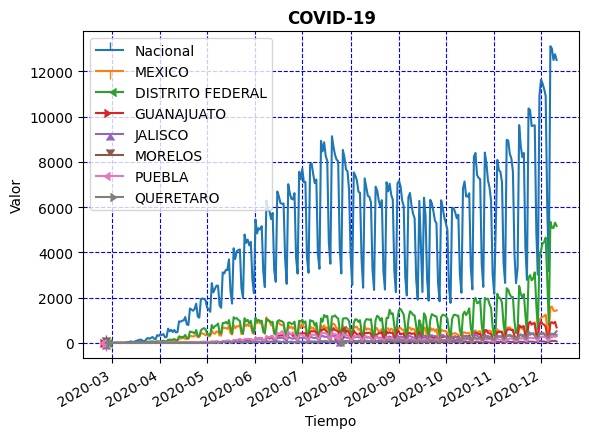

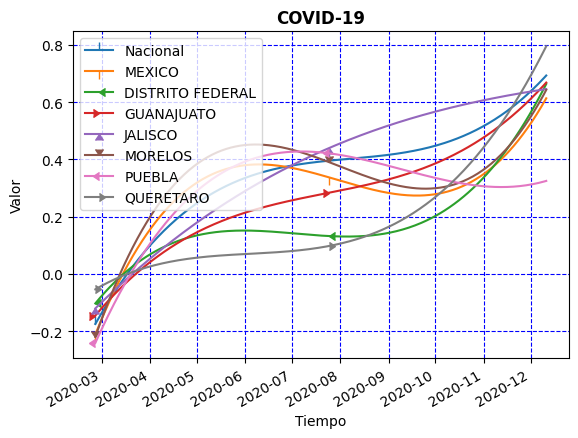

                 CORRELATION ANALYSIS
----------------------------------------------------------
                  Nacional    MEXICO  DISTRITO FEDERAL  GUANAJUATO   JALISCO  \
Nacional          1.000000  0.879905          0.846962    0.977791  0.963926   
MEXICO            0.879905  1.000000          0.773306    0.797412  0.727632   
DISTRITO FEDERAL  0.846962  0.773306          1.000000    0.906132  0.758837   
GUANAJUATO        0.977791  0.797412          0.906132    1.000000  0.963035   
JALISCO           0.963926  0.727632          0.758837    0.963035  1.000000   
MORELOS           0.818214  0.991266          0.691381    0.713531  0.649241   
PUEBLA            0.775409  0.837922          0.390842    0.627121  0.707866   
QUERETARO         0.797391  0.609155          0.965678    0.898229  0.771948   

                   MORELOS    PUEBLA  QUERETARO  
Nacional          0.818214  0.775409   0.797391  
MEXICO            0.991266  0.837922   0.609155  
DISTRITO FEDERAL  0.691381  0.39

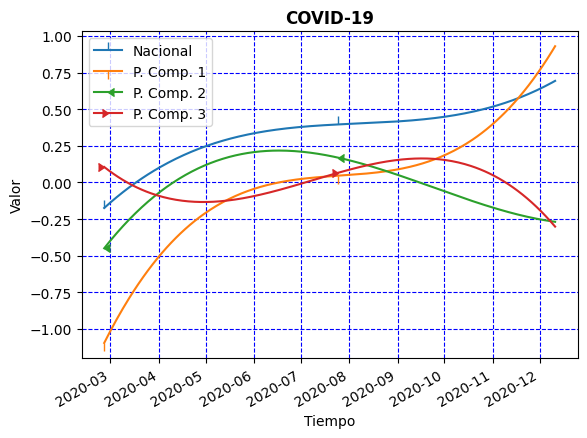



aqui
Estimated Parameters:
Number of trees (n_estimators): 4
Max depth of trees (max_depth): None


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0975 - mean_absolute_error: 0.2931 - val_loss: 0.1249 - val_mean_absolute_error: 0.3532 - learning_rate: 0.0100
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0591 - mean_absolute_error: 0.2302 - val_loss: 0.0825 - val_mean_absolute_error: 0.2869 - learning_rate: 0.0100
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0332 - mean_absolute_error: 0.1656 - val_loss: 0.0581 - val_mean_absolute_error: 0.2405 - learning_rate: 0.0100
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233 - mean_absolute_error: 0.1376 - val_loss: 0.0424 - val_mean_absolute_error: 0.2054 - learning_rate: 0.0100
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0183 - mean_absolute_error: 0.1180 - val_loss: 0.0322 - val_mean_absolute_error: 0.1786 - learning_rate: 0.0100
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129 - mean_absolute_error: 0.0966 - val_loss: 0.0266 - val_mean_absolute_error: 

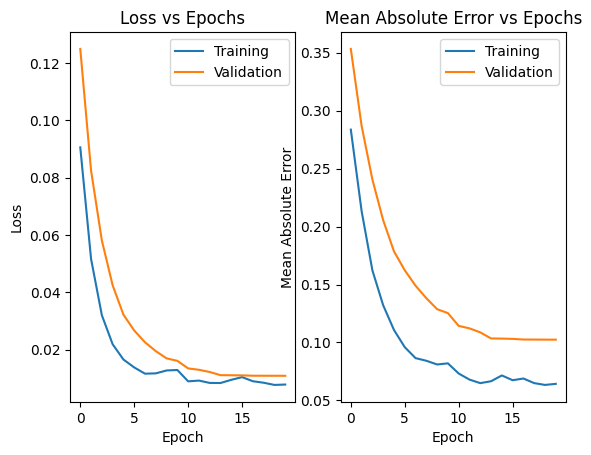

7/7 - 0s - 4ms/step - loss: 0.0036 - mean_absolute_error: 0.0484
[0.0036096940748393536, 0.04838376119732857]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
                      MODEL PERFORMANCE COMPARISON
-----------------------------------------------------------------------
                      Training
-----------------------------------------------------------------------
Model Performance           DT           RF          SVM       NN MLP
RSS                   0.020885     0.001194     0.902949     0.783304
SSR                   5.700755     5.675347     3.907308     2.840535
TSS                   5.721639     5.676542     4.810257     3.623839
R-Square               0.99635      0.99979     0.812287     0.783847
Adj. R-Square         0.996281     0.999786     0.808745     0.779769
AIC               -1985.432816  -2606.34097 -1168.071541 -1198.917111
APC                  -3.831865    -6.693193    -0.065223    -0.207369
BIC               -1998.95

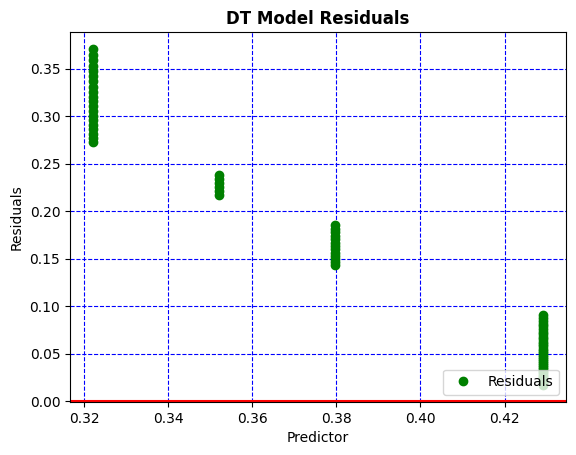

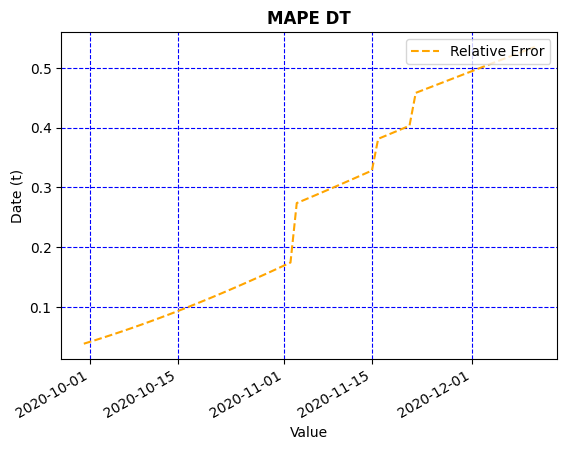

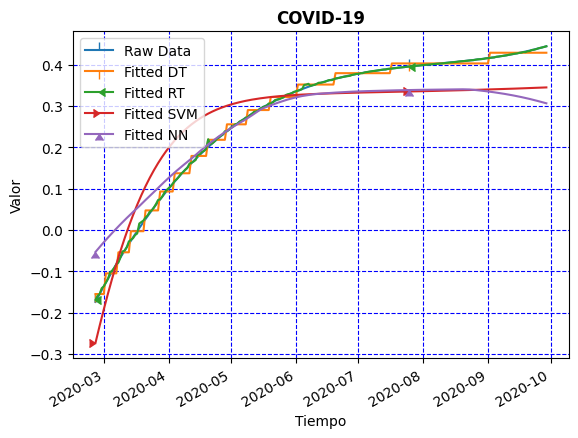

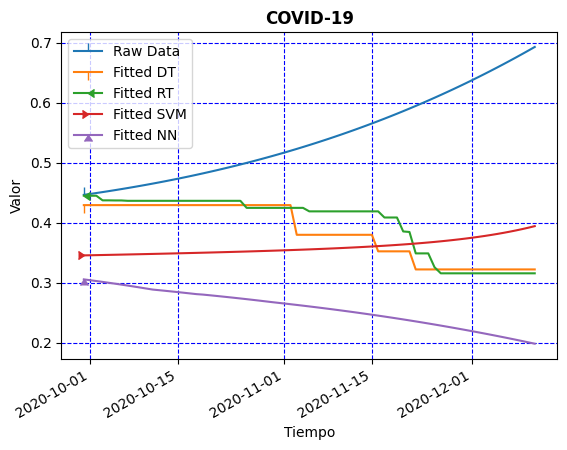

In [9]:
main()

In [ ]:
import re

mensaje = 'Hola, me gusta estudiar Python'
re.sub('\w{4},', 'Buenos días', mensaje)

'Buenos días me gusta estudiar Python'